# QCoDeS Example with Itacho

In this notebook, we show how to use Itacho in a simple setup. We sweep the current using a Keithley 2614B sourcemeter as the current source. Itacho 1211 will convert the current to voltage and we readout the voltage using a DMM Agilent 34401A. Our test setup is as the following picture:

![title](../files/ithaco_setup.png)

### Required imports

In [1]:
import time
from qcodes.instrument.base import Parameter

from qcodes.utils.dataset.doNd import do1d
from qcodes.dataset.plotting import plot_dataset
from qcodes import load_by_run_spec, load_or_create_experiment,\
initialise_or_create_database_at

from qcodes.instrument_drivers.tektronix.Keithley_2600_channels import\
Keithley_2600 as keith
import qcodes.instrument_drivers.agilent.Agilent_34400A as agi
import qcodes.instrument_drivers.ithaco.Ithaco_1211 as ithaco

In [2]:
from qcodes.logger import start_all_logging
start_all_logging()

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\QCoDeS_Public\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\QCoDeS_Public\.qcodes\logs\201106-16900-qcodes.log


### Connecting to the instruments

In [3]:
a1 = agi.Agilent_34400A('Agilent1', 'GPIB0::4::INSTR')
k1 = keith('Keithley', 'GPIB0::26::INSTR')

Connected to: HEWLETT-PACKARD 34401A (serial:0, firmware:10-5-2) in 0.24s
Connected to: Keithley Instruments Inc. 2614B (serial:4305420, firmware:3.2.2) in 0.06s


Itacho QCoDeS driver is only a virtual driver without any communication with the instrument. The instrument setting are only controlled via the front and back panel and the used QCoDeS setting must match its corresponding setting on the panel. Now, we instantiate an instance of the instrument:

In [4]:
camp = ithaco.Ithaco_1211('camp')

### Configuration

We set Amper per Volt Sensitivity here, which match with the setting on the panel (the rest of the setting are set according to their default values in the driver): 

In [5]:
camp.sens.set(1e-4)

Now, we use CurrentParameter class of Itacho to setup the following parameter, which is showing the fed current to the instantiated camp and converted voltage sent to our connected DMM via a1.volt.

In [6]:
curr = ithaco.CurrentParameter(a1.volt, camp)

Let's look at the present value of curr (the sourcemeter is not connected yet):

In [7]:
curr()

(0.000104574, -1.04574e-08)

The current value is practically zero. The voltage value is the current value devided by 1e-4 according to the setting camp.sens.set(1e-4). Thus, Itacho amplifies the feed. Our DMM is reading almost the same amplified voltage value:

In [8]:
a1.volt()

9.7097e-05

The units of the above values are:

In [9]:
curr.units

('V', 'A')

We set the integration time of our DMM as below:

In [10]:
a1.NPLC.set(1)

Let's look at the snapshot of our created Itacho instance

In [11]:
camp.snapshot()

{'functions': {},
 'submodules': {},
 '__class__': 'qcodes.instrument_drivers.ithaco.Ithaco_1211.Ithaco_1211',
 'parameters': {'IDN': {'__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'camp_IDN',
   'value': None,
   'raw_value': None,
   'ts': None,
   'instrument': 'qcodes.instrument_drivers.ithaco.Ithaco_1211.Ithaco_1211',
   'instrument_name': 'camp',
   'name': 'IDN',
   'inter_delay': 0,
   'unit': '',
   'vals': '<Anything>',
   'post_delay': 0,
   'label': 'IDN'},
  'sens': {'__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'camp_sens',
   'value': 0.0001,
   'raw_value': 0.0001,
   'ts': '2020-11-06 13:07:06',
   'instrument': 'qcodes.instrument_drivers.ithaco.Ithaco_1211.Ithaco_1211',
   'instrument_name': 'camp',
   'name': 'sens',
   'inter_delay': 0,
   'unit': 'A/V',
   'vals': '<Enum: {1e-09, 1e-05, 1e-08, 1e-10, 0.0001, 0.001, 1e-07, 1e-06, 1e-11}>',
   'post_delay': 0,
   'label': 'Sensitivity'},
  'invert': {'__class__': 'qcode

### Setting up qcodes database and performing a simple measurement

Now we want to feed our Itacho using our Keithley sourcemeter and run a simple qcodes measurement to see the output of the swept values passing through Itacho (for knowing how our sourcemeter works, you can refer to its qcodes notebook in this link https://qcodes.github.io/Qcodes/examples/driver_examples/Qcodes%20example%20with%20Keithley%202600.html):

We initilize a database named "itacho_db.db" and save our measured data there. Then, we create an experiment named "Itacho_measurement" or load it if is already created:

In [12]:
initialise_or_create_database_at('itacho_db.db')
exp = load_or_create_experiment('Itacho_measurement', sample_name='no sample')

Now, we would like to use qcodes do1d function to sweep over current values
generated by our sourcemeter and measure the current feeding to Itacho and converted voltage values by this instrument. qcodes Measurement can be also used for the same reason, instead.
To be able to use qcodes do1d function, we define a qcodes Paramater called volt_curr, which gets its swept values from the instantiated curr (we cannot use curr directly in the do1d function because of its structure defined in the driver):

In [13]:
volt_curr = Parameter('volt_curr', get_cmd=curr, unit='(V, A)')

Like curr, volt_curr will be a tuple, which its first and second values are converted voltage and fed current, respectively. The voltage values can be monitored on the connected DMM at every sweeping step, as well. We set our sourcemeter in the current mode and sweep from 1e-6 A to 1e-3 A in 20 steps with the interdelay of 1 second:

In [14]:
k1.smua.mode('current')

In [15]:
t1 = time.time()
do1d(k1.smua.curr, 1e-6, 1e-3, 20, 1, volt_curr, do_plot=False)
t2 = time.time()
print(f'Measurement took {t2-t1} seconds')

Starting experimental run with id: 2. 
Measurement took 21.335164785385132 seconds


As expected, the measurement took around 20 seconds. Now, we want to plot our measured dataset. We use qcodes to find the dataset that we want to plot in the database, and tweak plotting axes for showing it in a scatter plot. 

In [16]:
exp.data_set

<bound method Experiment.data_set of Itacho_measurement#no sample#1@C:\Users\QCoDeS_Public\Desktop\itacho_db.db
--------------------------------------------------------------------------
1-results-1-Keithley_smua_curr,volt_curr-40
2-results-2-Keithley_smua_curr,volt_curr-40>

In [17]:
dataset = load_by_run_spec(experiment_name='Itacho_measurement',\
                           captured_run_id=2)

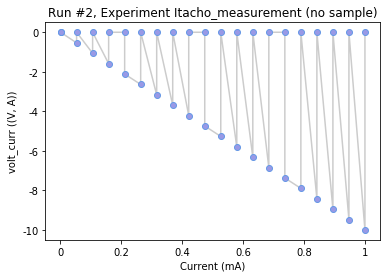

In [18]:
axes, cbax = plot_dataset(dataset)
axes[0].lines[0].set_marker('o')
axes[0].lines[0].set_markerfacecolor((0.6, 0.6, 0.9))
axes[0].lines[0].set_markeredgecolor((0.4, 0.6, 0.9))
axes[0].lines[0].set_color((0.8, 0.8, 0.8))

We plotted the result in a simple 1D-plot rather than 2D-plot to better show the obtained values. We see two results: the almost horizontally aligned blue cirles are the current values of volt_curr and the rest is the converted voltages at each sweeping step. If we look at our attached DMM, we see that it is showing -10.00 V DC, which is the same as the final voltage value in the figure.

Let's explore our dataset, because why not :)

In [19]:
dataset.get_data_as_pandas_dataframe()['volt_curr']

,volt_curr
Keithley_smua_curr,
0.000001,-9.897549e-03
0.000001,9.897549e-07
0.000054,-5.360914e-01
0.000054,5.360914e-05
0.000106,-1.062385e+00
0.000106,1.062385e-04
0.000159,-1.588474e+00
0.000159,1.588474e-04
0.000211,-2.114559e+00


Because of the tuple structure of volt_curr, we see every sweeping step (the first column) stored twice, meaning the top value of each step in the second column is the amplified voltage and the bottom one is the fed current, which is very close to the current value coming from the source in the first column. 